# Tutorial: Removing Cross-Swath Bias in `ssha_karin_2`

---
**Author**: Jinbo Wang   
**Date**: 9/7/2023  
**Revison History**

---
⚠️ **Disclaimer: Preliminary** ⚠️

_This project is currently in the process of reprocessing the data. The SWOT data should not be used for scientific analyses. The code provided here is aimed at demonstrating basic techniques for data access, processing, and visualization._

### Prerequisites
Before proceeding with this tutorial, you'll need to download the SWOT KaRIn Expert product. This code is explicit on visualization. Major analysis is done by the routine `swot_ssh_utils.fit_bias`. 

<xarray.Dataset>
Dimensions:                                (num_lines: 626, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 33.01 ... 43.98
    longitude_nadir                        (num_lines) float64 233.9 ... 237.1
    latitude                               (num_lines, num_pixels) float64 33...
    longitude                              (num_lines, num_pixels) float64 23...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/96)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    sea_state_bias_cor                     (num_lines, num_pixels) float32 ...
    sea_state_bias_cor_2                   (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-08-24T21:35:04Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   JPL
    references:                                    V1.1
    equator_time:                                  2023-04-23T04:46:35.954000Z
    equator_longitude:                             -131.84
    product_version:                               01

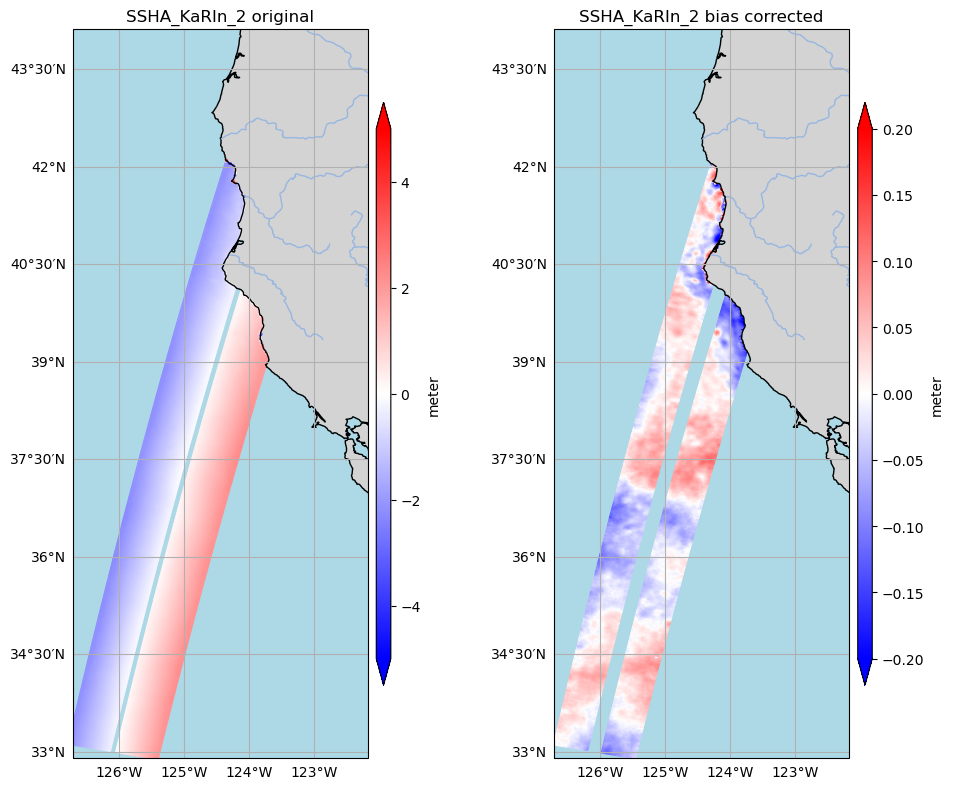

In [1]:
import pylab as plt
import numpy as np
import sys
sys.path.append('../src/')
import swot_ssh_utils as swot
from cartopy import crs as ccrs

def load_and_plot_ssha_data(pth, fn, lat_bounds):
    """
    Load and plot Sea Surface Height Anomaly (SSHA) data.
    
    Parameters:
    pth (str): Path to the file
    fn (str): Filename of the data
    lat_bounds (list): Latitude bounds for the data
    
    Returns:
    None
    """
    # Load data
    data = swot.SSH_L2()
    data.load_data(pth + fn, lat_bounds=lat_bounds)
    display(data.Expert)
    
    # Preprocess data
    ssha = data.Expert.ssha_karin_2
    flag = data.Expert.ancillary_surface_classification_flag
    ssha = np.where(flag == 0, ssha, np.nan)
    lon = data.Expert.longitude.values
    lat = data.Expert.latitude.values
    distance = data.Expert.cross_track_distance.values
    
    # Create plots
    fig, ax = plt.subplots(
        figsize=(10, 8),
        ncols=2,
        nrows=1,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    
    # Plot original data
    swot.plot_a_segment(ax[0], lon, lat, ssha, title='SSHA_KaRIn_2 original', vmin=-5, vmax=5)
    
    # Bias correction (optional)
    ssha_1 = swot.fit_bias(
        ssha, distance,
        check_bad_point_threshold=0.1,
        remove_along_track_polynomial=True
    )
    
    # mask out data in nadir and outside of 60km swath width
    distance = np.nanmean(distance, axis=0 )
    msk = (np.abs(distance) < 60e3) & (np.abs(distance) > 10e3)
    lon[:, ~msk] = np.nan
    lat[:, ~msk] = np.nan
    ssha_1[:, ~msk] = np.nan

    # Plot bias corrected data
    swot.plot_a_segment(ax[1], lon, lat, ssha_1, title='SSHA_KaRIn_2 bias corrected', vmin=-0.2, vmax=0.2)
    
    # Save and display plot
    plt.tight_layout()
    plt.savefig('../media/figures/ssha_karin_2_california.png', dpi=100)


# Change the following for your region of interest.

pass_num='013'
pth = '/home/wangjinb/swot/KaRIn/SWOT_L2_LR_SSH_1.1/' #path to your data
fn = f'SWOT_L2_LR_SSH_Expert_499_{pass_num}_20230423T042206_20230423T051104_PIB0_01.nc' #filename of your data

# Latitude bounds
lat_bounds = [33, 44]

# Execute the function
load_and_plot_ssha_data(pth, fn, lat_bounds)